# MNIST Occlusion Dataset

In this notebook, we will generate the new test dataset called **mnist_occ_black**, **mnist_occ_white**, **mnist_occ_gauss**, and **mnist_occ_natural**. This dataset will generated from several type of occlusions:
1. Black noise
2. White noise
3. Random Gaussian noise
4. Natural object image

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))

import cv2
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from PIL import Image

from Code.dataset_helpers import filelist_reader

In [2]:
# image path
root = '../dataset/MNIST_224X224_3'
gauss_noise = 'noise.jpg'
natural_object = 'natural_object.jpg'
test_data = 'test'
annot_file = 'pairs_test.txt'

## Helper Functions

Below are some helper functions that will be used to generate the occluded dataset. 

In [3]:
def load_occluders(root, img_path):
    img = Image.open(os.path.join(root, img_path))
    img = img.resize((224,224))
    occluder = np.asarray(img)
    return occluder


def black_noise(size = (224, 224,3)):
    return np.zeros(size, dtype = np.uint8)


def white_noise(size = (224, 224,3)):
    return 255 * np.ones(size, dtype=np.uint8)
    
    
def resize_image(img, scale_factor):
    new_size = (int(img.shape[0] * scale_factor), int(img.shape[1] * scale_factor))
    return cv2.resize(img, new_size, fx=scale_factor, fy=scale_factor, interpolation = cv2.INTER_AREA)
    
    
def occlude_with_noise(img, occluder, shift=30, num_occlusion = 1):
    result = img.copy()
    img_size = np.asarray([img.shape[1], img.shape[0]])
    scale_factor = min(img_size) / 224
    
    count = num_occlusion
    
    for _ in range(count):
        # resize the occluder
        random_scale_factor = np.random.uniform(0.4, 0.6)
        occ_scale_factor = scale_factor * random_scale_factor
        occluder = resize_image(occluder, occ_scale_factor)
        
        occ_center = np.random.uniform([shift,shift], img_size-shift)
        put_occlusion(occluder, result, occ_center)
        
    return result
        
        
def put_occlusion(img_src, img_dst, center):
    '''
    Put source image to destination image at specified center
    '''
    src_size = np.asarray([img_src.shape[1], img_src.shape[0]])
    dst_size = np.asarray([img_dst.shape[1], img_dst.shape[0]])
    
    # region of destination image that will be occluded
    center = center.astype(int)
    raw_start_dst = center - src_size // 2 # top left
    raw_end_dst = raw_start_dst + src_size # bottom right
    start_dst = np.clip(raw_start_dst, 0, dst_size)
    end_dst = np.clip(raw_end_dst, 0, dst_size)
    
    # region of source image to be extracted
    start_src = start_dst - raw_start_dst
    end_src = src_size +(end_dst - raw_end_dst)

    occ = img_src[start_src[1]:end_src[1], start_src[0]:end_src[0]]
    
    # occlusion
    img_dst[start_dst[1]:end_dst[1], start_dst[0]:end_dst[0]] = occ

## Visualization

In this section, we will visualize the occluders that we are going to use and try to put them into sample test dataset to see whether the occlusion is reasonable. As stated before, we will use four types of occlusion: **black noise**, **random gaussian noise**, and **natural object**.

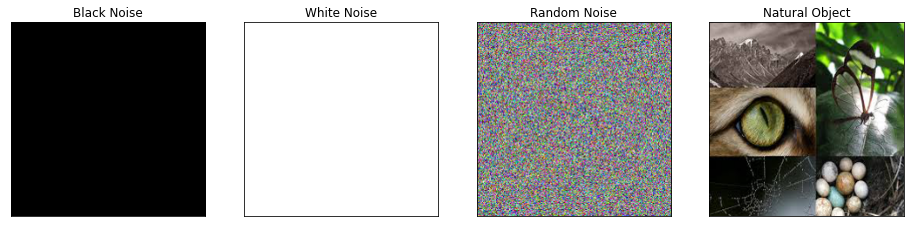

In [4]:
# show occluders
fig, ax = plt.subplots(1,4, figsize = (16,4))
ax = ax.flat

blk = black_noise()
ax[0].imshow(blk)
ax[0].set_title("Black Noise")

white = white_noise()
ax[1].imshow(white)
ax[1].set_title("White Noise")

gauss = load_occluders(root, gauss_noise)
ax[2].imshow(gauss)
ax[2].set_title("Random Noise")

natural = load_occluders(root, natural_object)
ax[3].imshow(natural)
ax[3].set_title("Natural Object")

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])

plt.show()

In [5]:
# load the annotation file
image_list = filelist_reader(os.path.join(root, annot_file))
print(f"Number of images in test set: {len(image_list)}")

Number of images in test set: 10000


First we will visualize some results from the occlusion with **black noise**. 
The left side of the figure shows the original images, while the right side shows the occluded images.
Run below cell multiple times to see more about this occlusion.

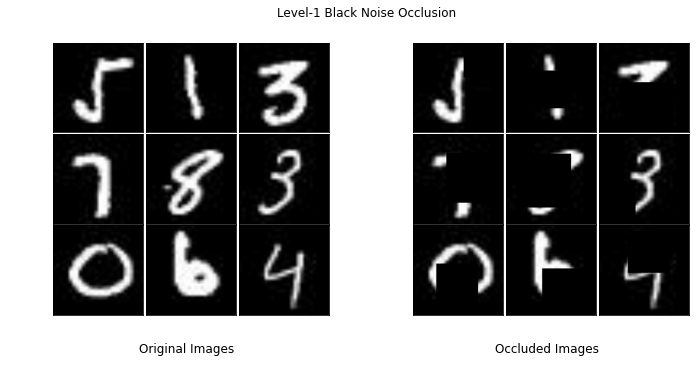

In [6]:
# run this cell multiple times
occluder = black_noise()
rng = default_rng()
index = rng.choice(len(image_list), size = 9, replace = False)

fig = plt.figure(figsize = (10, 5))
fig.suptitle("Level-1 Black Noise Occlusion")
subfigs = fig.subfigures(1, 2, wspace = 0.01, hspace = 0.01)

ax0 = subfigs[0].subplots(3,3)
ax0 = ax0.flat
ax1 = subfigs[1].subplots(3,3)
ax1 = ax1.flat

for num, data_idx in enumerate(index):
    img_path, label = image_list[data_idx]
    sample_img = np.asarray(Image.open(os.path.join(root, test_data, img_path)))
    occluded_img = occlude_with_noise(sample_img, occluder, num_occlusion=1) # level-1 occlusion
    
    ax0[num].imshow(sample_img)
    ax1[num].imshow(occluded_img)
    
subfigs[0].supxlabel("Original Images")
subfigs[1].supxlabel("Occluded Images")

for axis in ax0:
    axis.set_xticks([])
    axis.set_yticks([])

for axis in ax1:
    axis.set_xticks([])
    axis.set_yticks([])
    
plt.subplots_adjust(wspace = 0.002, hspace = 0.02)
plt.show()

Now we will see the level-2 **white noise** occlusion. The left side shows the original image, while the right one shows the occluded image. Run below cell multiple times to see more about this occlusion. 

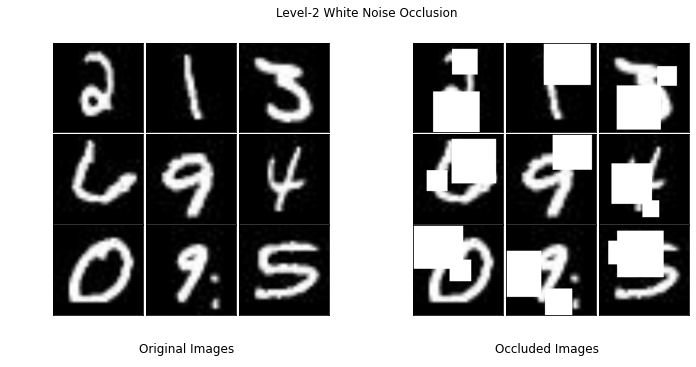

In [7]:
# run this cell multiple times
occluder = white_noise()
rng = default_rng()
index = rng.choice(len(image_list), size = 9, replace = False)

fig = plt.figure(figsize = (10, 5))
fig.suptitle("Level-2 White Noise Occlusion")
subfigs = fig.subfigures(1, 2, wspace = 0.01, hspace = 0.01)

ax0 = subfigs[0].subplots(3,3)
ax0 = ax0.flat
ax1 = subfigs[1].subplots(3,3)
ax1 = ax1.flat

for num, data_idx in enumerate(index):
    img_path, label = image_list[data_idx]
    sample_img = np.asarray(Image.open(os.path.join(root, test_data, img_path)))
    occluded_img = occlude_with_noise(sample_img, occluder, num_occlusion=2) # level-2 occlusion
    
    ax0[num].imshow(sample_img)
    ax1[num].imshow(occluded_img)
    
subfigs[0].supxlabel("Original Images")
subfigs[1].supxlabel("Occluded Images")

for axis in ax0:
    axis.set_xticks([])
    axis.set_yticks([])

for axis in ax1:
    axis.set_xticks([])
    axis.set_yticks([])
    
plt.subplots_adjust(wspace = 0.002, hspace = 0.02)
plt.show()

Next, we will level-3 occlusion using **random gaussian noise**.
The left side of the figure shows the original images, while the right side shows the occluded images.
Run below cell multiple times to see more about this occlusion.

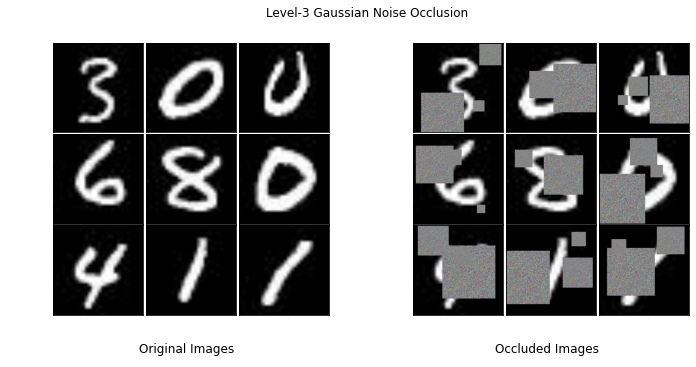

In [8]:
# run this cell multiple times
occluder = load_occluders(root, gauss_noise)
rng = default_rng()
index = rng.choice(len(image_list), size = 9, replace = False)

fig = plt.figure(figsize = (10, 5))
fig.suptitle("Level-3 Gaussian Noise Occlusion")
subfigs = fig.subfigures(1, 2, wspace = 0.01, hspace = 0.01)

ax0 = subfigs[0].subplots(3,3)
ax0 = ax0.flat
ax1 = subfigs[1].subplots(3,3)
ax1 = ax1.flat

for num, data_idx in enumerate(index):
    img_path, label = image_list[data_idx]
    sample_img = np.asarray(Image.open(os.path.join(root, test_data, img_path)))
    occluded_img = occlude_with_noise(sample_img, occluder, num_occlusion=3)
    
    ax0[num].imshow(sample_img)
    ax1[num].imshow(occluded_img)
    
subfigs[0].supxlabel("Original Images")
subfigs[1].supxlabel("Occluded Images")

for axis in ax0:
    axis.set_xticks([])
    axis.set_yticks([])

for axis in ax1:
    axis.set_xticks([])
    axis.set_yticks([])
    
plt.subplots_adjust(wspace = 0.002, hspace = 0.02)
plt.show()

Now we will see the level-1 occlusion using **natural object**.
Same as before, the left side of the figure shows the original images, while the right side shows the occluded images.
Run below cell multiple times to see more about this occlusion.

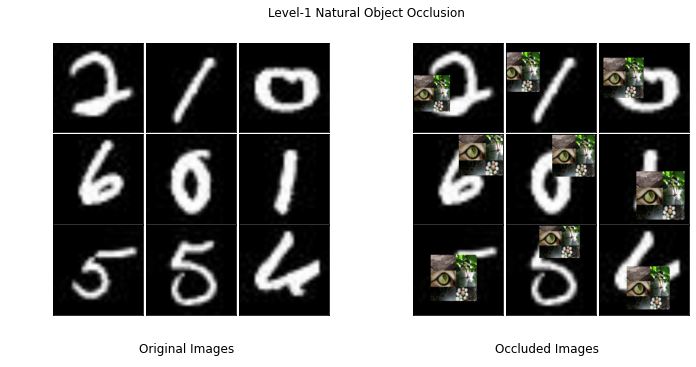

In [9]:
# run this cell multiple times
occluder = load_occluders(root, natural_object)
rng = default_rng()
index = rng.choice(len(image_list), size = 9, replace = False)

fig = plt.figure(figsize = (10, 5))
fig.suptitle("Level-1 Natural Object Occlusion")
subfigs = fig.subfigures(1, 2, wspace = 0.01, hspace = 0.01)

ax0 = subfigs[0].subplots(3,3)
ax0 = ax0.flat
ax1 = subfigs[1].subplots(3,3)
ax1 = ax1.flat

for num, data_idx in enumerate(index):
    img_path, label = image_list[data_idx]
    sample_img = np.asarray(Image.open(os.path.join(root, test_data, img_path)))
    occluded_img = occlude_with_noise(sample_img, occluder, num_occlusion=1)
    
    ax0[num].imshow(sample_img)
    ax1[num].imshow(occluded_img)
    
subfigs[0].supxlabel("Original Images")
subfigs[1].supxlabel("Occluded Images")

for axis in ax0:
    axis.set_xticks([])
    axis.set_yticks([])

for axis in ax1:
    axis.set_xticks([])
    axis.set_yticks([])
    
plt.subplots_adjust(wspace = 0.002, hspace = 0.02)
plt.show()

From the visualization figures above, we can see that the occlusion seems to be reasonable. So we are ready to generate the occluded test.

## Generate Occluded Test

Now we are ready to generate the occluded test dataset. We will save them into the same root folder of original MNIST dataset.

In [10]:
# image path
root = '../dataset/MNIST_224X224_3'
gauss_noise = 'noise.jpg'
natural_object = 'natural_object.jpg'
test_data = 'test'
annot_file = 'pairs_test.txt'

# save path
occ_black_1 = 'test_occ_black_1'
occ_white_2 = 'test_occ_white_2'
occ_gauss_3 = 'test_occ_gauss_3'
occ_natural_1 = 'test_occ_natural_1'

In [11]:
# generate level-1 mnist_test_occ_black
occluder = black_noise()

for img_path, label in image_list:
    img_dir, img_file = img_path.split('/')
    
    img = np.asarray(Image.open(os.path.join(root, test_data, img_path)))
    occluded_img = occlude_with_noise(img, occluder, num_occlusion=1)
    occluded_img = Image.fromarray(occluded_img)
    
    # save the image
    save_dir = os.path.join(root, occ_black_1, img_dir)
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    occluded_img.save(os.path.join(save_dir, img_file))
print(f"mnist_occ_black_1 is saved into: {os.path.join(root, occ_black_1)}")

mnist_occ_black_1 is saved into: ../dataset/MNIST_224X224_3/test_occ_black_1


In [12]:
# generate level-2 mnist_test_occ_white
occluder = white_noise()

for img_path, label in image_list:
    img_dir, img_file = img_path.split('/')
    
    img = np.asarray(Image.open(os.path.join(root, test_data, img_path)))
    occluded_img = occlude_with_noise(img, occluder, num_occlusion=2)
    occluded_img = Image.fromarray(occluded_img)
    
    # save the image
    save_dir = os.path.join(root, occ_white_2, img_dir)
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    occluded_img.save(os.path.join(save_dir, img_file))
print(f"mnist_occ_white_2 is saved into: {os.path.join(root, occ_white_2)}")

mnist_occ_white_2 is saved into: ../dataset/MNIST_224X224_3/test_occ_white_2


In [13]:
# generate level-3 mnist_test_occ_gauss
occluder = load_occluders(root, gauss_noise)

for img_path, label in image_list:
    img_dir, img_file = img_path.split('/')
    
    img = np.asarray(Image.open(os.path.join(root, test_data, img_path)))
    occluded_img = occlude_with_noise(img, occluder, num_occlusion=3)
    occluded_img = Image.fromarray(occluded_img)
    
    # save the image
    save_dir = os.path.join(root, occ_gauss_3, img_dir)
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    occluded_img.save(os.path.join(save_dir, img_file))
print(f"mnist_occ_gauss_3 is saved into: {os.path.join(root, occ_gauss_3)}")

mnist_occ_gauss_3 is saved into: ../dataset/MNIST_224X224_3/test_occ_gauss_3


In [14]:
# generate level-1 mnist_test_occ_natural
occluder = load_occluders(root, natural_object)

for img_path, label in image_list:
    img_dir, img_file = img_path.split('/')
    
    img = np.asarray(Image.open(os.path.join(root, test_data, img_path)))
    occluded_img = occlude_with_noise(img, occluder, num_occlusion=1)
    occluded_img = Image.fromarray(occluded_img)
    
    # save the image
    save_dir = os.path.join(root, occ_natural_1, img_dir)
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    occluded_img.save(os.path.join(save_dir, img_file))
print(f"mnist_occ_natural_1 is saved into: {os.path.join(root, occ_natural_1)}")

mnist_occ_natural_1 is saved into: ../dataset/MNIST_224X224_3/test_occ_natural_1
